# ОИАД. Лабораторная работа №3


In [508]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import RegressorMixin

In [509]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [510]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [511]:
df.shape

(1338, 7)

### 1. Подготовка данных

* 1.1 проверить наличие пропусков и выбросов

In [512]:
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [513]:
numeric_cols = df.select_dtypes(include=np.number).columns

In [514]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    print(f"{col}: выбросов {len(outliers)}")

age: выбросов 0
bmi: выбросов 9
children: выбросов 0
charges: выбросов 138


In [515]:
df.shape

(1191, 7)

In [516]:
1338 - 1191

147

# 1.2 привести категориальные признаки к числовым

In [517]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['sex', 'smoker', 'region'], dtype='object')

In [518]:
df_encoded = pd.get_dummies(df, drop_first=True, dtype=int)

In [519]:
df.shape

(1191, 7)

In [520]:
df_encoded.shape

(1191, 9)

In [521]:
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


# 1.3 вычислить парные корреляции признаков

In [522]:
corr_matrix = df_encoded.corr()

In [523]:
display(corr_matrix.round(2))

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.00,0.12,0.04,0.45,-0.02,-0.06,-0.00,-0.02,0.02
bmi,0.12,1.00,0.01,-0.06,0.02,-0.26,-0.11,0.23,0.01
children,0.04,0.01,1.00,0.09,0.02,-0.00,0.01,-0.01,0.03
charges,0.45,-0.06,0.09,1.00,-0.02,0.60,0.04,-0.03,-0.08
sex_male,-0.02,0.02,0.02,-0.02,1.00,0.01,0.00,-0.00,-0.01
smoker_yes,-0.06,-0.26,-0.00,0.60,0.01,1.00,0.02,-0.00,-0.05
region_northwest,-0.00,-0.11,0.01,0.04,0.00,0.02,1.00,-0.34,-0.33
region_southeast,-0.02,0.23,-0.01,-0.03,-0.00,-0.00,-0.34,1.00,-0.33
region_southwest,0.02,0.01,0.03,-0.08,-0.01,-0.05,-0.33,-0.33,1.00


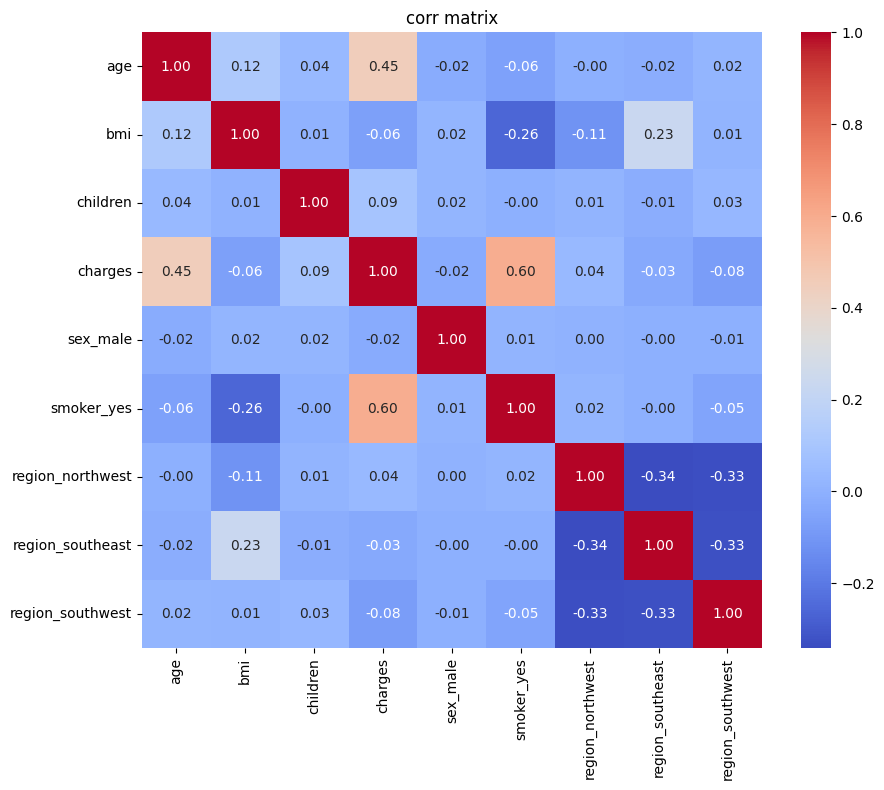

In [524]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("corr matrix")
plt.show()

### 2-3 Многомерная линейная регрессия

Построить модель линейной регрессии и подобрать параметры:

* аналитически (реализовать самому)

In [525]:
y = df_encoded["charges"]
X = df_encoded.drop(columns="charges")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [526]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [527]:
def analytical_solution(X, y, lambda_reg=0):
    X_with_bias = np.c_[np.ones(X.shape[0]), X]

    if lambda_reg > 0:
        reg = np.eye(X_with_bias.shape[1])
        reg[0, 0] = 0
        weights = np.linalg.inv(
            X_with_bias.T @ X_with_bias + lambda_reg * reg
        ) @ X_with_bias.T @ y
    else:
        weights = np.linalg.pinv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
    return weights

* Численно, с помощью методов градиентного спуска (реализовать самому)

In [528]:
class SGDLinearRegressor(RegressorMixin):
    def __init__(self,
                 lr=0.01, regularization=0., delta_converged=1e-3, max_steps=1000,
                 batch_size=64):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size

        self.W = None
        self.b = None

    def fit(self, X, Y):
        n_samples, n_features = X.shape
        X, Y = np.array(X), np.array(Y)
        self.W = np.random.normal(size=n_features)
        self.b = 0

        for _ in range(self.max_steps):
            indexes = np.random.choice(n_samples, size=self.batch_size, replace=False)
            X_batch, y_batch = X[indexes], Y[indexes]
            preds = X_batch @ self.W + self.b
            loss = np.mean((y_batch - preds) ** 2) + self.regularization * (self.W.T @ self.W)
            W_gradient = (2 / self.batch_size) * (X_batch.T @ (preds - y_batch)) + 2 * self.regularization * self.W
            b_gradient = (2 / self.batch_size) * np.sum(preds - y_batch)

            W_new = self.W - self.lr * W_gradient
            b_new = self.b - self.lr * b_gradient

            if np.linalg.norm(self.W - W_new) < self.delta_converged:
                break
            else:
                self.W = W_new
                self.b = b_new

        return self

    def predict(self, X):
        X = np.array(X)
        return np.array(X @ self.W + self.b)

In [529]:
weights_analytical = analytical_solution(X_train, y_train)
print(f"Weights: {weights_analytical}")

Weights: [9878.12647101 3437.6221265   480.68665225  662.82565945 -164.3621441
 4777.79221746  -30.21005638 -503.2404289  -603.89241764]


In [530]:
lr_gradient = SGDLinearRegressor(lr=0.1, max_steps=1000)
lr_gradient.fit(X_train, y_train)

print(f"Weights: {lr_gradient.W}")
print(f"Bias: {lr_gradient.b}")

Weights: [3866.48260934  303.78935861  464.61265448 -237.95213908 4506.24977034
 -406.76215151 -206.00149205 -455.45597192]
Bias: 9713.85920054072


In [531]:
weights_ridge_analytical = analytical_solution(X_train, y_train, lambda_reg=1)
print(f"Weights with regularization: {weights_ridge_analytical}")

Weights with regularization: [9878.12647101 3433.95519138  478.91659367  662.27666777 -164.0955397
 4772.10142058  -29.30064112 -501.4835633  -602.40668533]


In [532]:
lr_ridge_gradient = SGDLinearRegressor(lr=0.1, max_steps=1000, regularization=1)
lr_ridge_gradient.fit(X_train, y_train)

print(f"Weights: {lr_gradient.W}")
print(f"Bias: {lr_gradient.b}")

Weights: [3866.48260934  303.78935861  464.61265448 -237.95213908 4506.24977034
 -406.76215151 -206.00149205 -455.45597192]
Bias: 9713.85920054072


### 3. Оценка обобщающей способности

In [533]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(calculate_mse(y_true, y_pred))

In [534]:
y_pred_constant = np.full_like(y_test, np.mean(y_train))
print(f"Constant MSE: {calculate_mse(y_test, y_pred_constant)}\nConstant RMSE: {calculate_rmse(y_test, y_pred_constant)}")

Constant MSE: 44135629.58883649
Constant RMSE: 6643.465179319937


In [535]:
X_test_with_bias = np.c_[np.ones(X_test.shape[0]), X_test]
y_pred_analytical = np.dot(X_test_with_bias, weights_analytical)
print(f"Analytical MSE: {calculate_mse(y_test, y_pred_analytical)}\nAnalytical RMSE: {calculate_rmse(y_test, y_pred_analytical)}")

Analytical MSE: 20476853.081808034
Analytical RMSE: 4525.135697612618


In [536]:
y_pred_gradient = lr_gradient.predict(X_test)
print(f"Gradient descent MSE: {calculate_mse(y_test, y_pred_gradient)}\nGradient descent RMSE: {calculate_rmse(y_test, y_pred_gradient)}")

Gradient descent MSE: 20119632.094052907
Gradient descent RMSE: 4485.491287925204


In [537]:
y_pred_ridge_analytical = np.dot(X_test_with_bias, weights_ridge_analytical)
print(f"Analytical with ridge MSE: {calculate_mse(y_test, y_pred_ridge_analytical)}\nAnalytical with ridge RMSE: {calculate_rmse(y_test, y_pred_ridge_analytical)}")

Analytical with ridge MSE: 20470524.832196295
Analytical with ridge RMSE: 4524.436410448963


In [538]:
y_pred_ridge_gradient = lr_ridge_gradient.predict(X_test)
print(f"Gradient descent with ridge MSE: {calculate_mse(y_test, y_pred_ridge_gradient)}\nGradient descent with ridge RMSE: {calculate_rmse(y_test, y_pred_ridge_gradient)}")

Gradient descent with ridge MSE: 25197945.699467536
Gradient descent with ridge RMSE: 5019.755541803558
